Train 124  Val 31  Test 34
🛠  Best params: {'decisiontreeregressor__max_depth': 8, 'decisiontreeregressor__min_samples_leaf': 2}

--- Grey-Box DT 评估 ---
VAL  :  Vmpp RMSE= 0.127 V  R²= 0.994 | Pmpp RMSE=  1.85 W  R²= 1.000
TEST :  Vmpp RMSE= 0.166 V  R²= 0.988 | Pmpp RMSE=  2.45 W  R²= 0.999


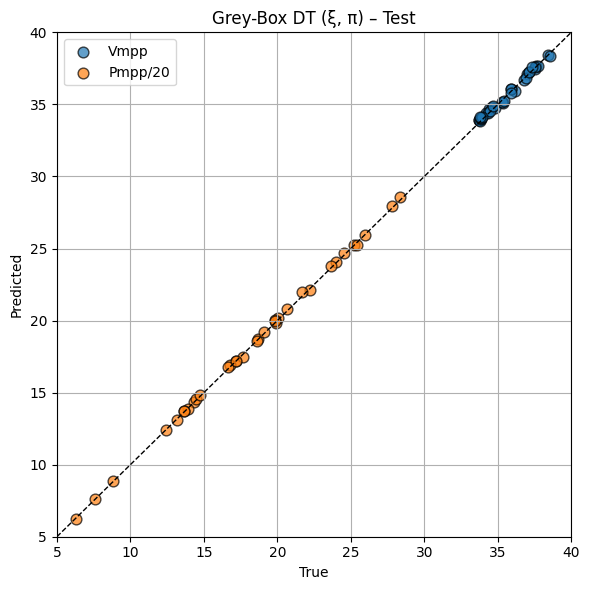


✅  灰盒模型已保存为 dt_greybox_xi_pi.pkl


In [10]:
# ================================================================
#  Grey-Box Decision Tree  (ξ, π)  —— Vmpp & Pmpp 复原
#  依赖文件：pv_mpp_dataset_graybox.csv
# ================================================================
!pip install -q scikit-learn pandas numpy matplotlib

import pandas as pd, numpy as np, matplotlib.pyplot as plt, inspect, joblib
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# ---------- 1. 读取含 Voc, Isc, ξ, π 的灰盒数据 -------------------------
df = pd.read_csv('/content/pv_mpp_dataset_graybox.csv')

# ---------- 2. 分组切分：同一基准网格整组进入同一集合 -------------------
df['gid'] = (df['Ir']//100)*100 + ((df['T']+0.1)//5)*5
gss = GroupShuffleSplit(test_size=0.2, random_state=0)
tr_idx, te_idx = next(gss.split(df, groups=df['gid']))
train_df, test_df = df.iloc[tr_idx], df.iloc[te_idx]

train_df = train_df.sample(frac=1, random_state=0)      # shuffle
val_cut  = int(0.8 * len(train_df))
val_df   = train_df.iloc[val_cut:];  train_df = train_df.iloc[:val_cut]

print(f'Train {len(train_df)}  Val {len(val_df)}  Test {len(test_df)}')

# ---------- 3. 选择特征 / 标签 ------------------------------------------
#   方案 A：只用 (Ir,T) 作为输入  → 充分展示“灰盒先验”的效果
X_train, X_val, X_test = (train_df[['Ir','T']],
                          val_df  [['Ir','T']],
                          test_df [['Ir','T']])

y_train = train_df[['xi','pi']].values        # 标签 = 归一化 ξ, π
y_val   = val_df  [['xi','pi']].values
y_test  = test_df [['xi','pi']].values

# ---------- 4. 灰盒决策树 + 简易网格搜索调参 ----------------------------
pipe = make_pipeline(StandardScaler(),
                     DecisionTreeRegressor(random_state=0))
param_grid = {'decisiontreeregressor__max_depth':[4,5,6,8],
              'decisiontreeregressor__min_samples_leaf':[1,2,4]}
gkf  = GroupKFold(n_splits=5)
grid = GridSearchCV(pipe, param_grid,
                    cv=gkf.split(X_train, y_train[:,0], groups=train_df['gid']),
                    scoring='neg_root_mean_squared_error',
                    n_jobs=-1).fit(X_train, y_train)
best_dt = grid.best_estimator_
print('🛠  Best params:', grid.best_params_)

# ---------- 5. 评估函数 --------------------------------------------------
def rmse(a,b):
    sig = inspect.signature(mean_squared_error)
    return mean_squared_error(a,b,squared=False) if 'squared' in sig.parameters \
           else np.sqrt(mean_squared_error(a,b))

def evaluate(X, y, df_meta, tag):
    pred_norm = best_dt.predict(X)          # 预测 ξ̂, π̂
    Vm_hat = pred_norm[:,0] * df_meta['Voc'].values
    Pm_hat = pred_norm[:,1] * df_meta['Voc'].values * df_meta['Isc'].values
    Vm_true, Pm_true = df_meta['Vmpp'].values, df_meta['Pmpp'].values
    rv = rmse(Vm_true, Vm_hat); r2v = r2_score(Vm_true, Vm_hat)
    rp = rmse(Pm_true, Pm_hat); r2p = r2_score(Pm_true, Pm_hat)
    print(f'{tag:<5}:  Vmpp RMSE={rv:6.3f} V  R²={r2v:6.3f} | '
          f'Pmpp RMSE={rp:6.2f} W  R²={r2p:6.3f}')
    return Vm_hat, Pm_hat

print('\n--- Grey-Box DT 评估 ---')
_      = evaluate(X_val,  y_val,  val_df,  'VAL')
Vm_hat, Pm_hat = evaluate(X_test, y_test, test_df, 'TEST')

# ---------- 6. 散点图 ----------------------------------------------------
plt.figure(figsize=(6,6))
plt.scatter(test_df['Vmpp'], Vm_hat,
            c='tab:blue', label='Vmpp', alpha=.7, edgecolors='k', s=60)
plt.scatter(test_df['Pmpp']/20, Pm_hat/20,
            c='tab:orange', label='Pmpp/20', alpha=.7, edgecolors='k', s=60)

all_true = np.concatenate([test_df['Vmpp'], test_df['Pmpp']/20])
all_pred = np.concatenate([Vm_hat,          Pm_hat/20])
low, high = np.floor(min(all_true.min(), all_pred.min())-1), np.ceil(max(all_true.max(), all_pred.max())+1)
plt.plot([low, high], [low, high], 'k--', lw=1)
plt.xlim(low, high); plt.ylim(low, high)
plt.xlabel('True'); plt.ylabel('Predicted')
plt.title('Grey-Box DT (ξ, π) – Test'); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# ---------- 7. 保存模型 ---------------------------------------------------
joblib.dump(best_dt, '/content/dt_greybox_xi_pi.pkl')
print('\n✅  灰盒模型已保存为 dt_greybox_xi_pi.pkl')

Train=124  Val=31  Test=34
🛠  Best SVR params: {'multioutputregressor__estimator__C': 1, 'multioutputregressor__estimator__epsilon': 0.01, 'multioutputregressor__estimator__gamma': 'scale'}

--- SVR (ξ, π) 评估 ---
VAL  : Vmpp RMSE= 0.279 V  R²= 0.970 | Pmpp RMSE=  3.31 W  R²= 1.000
TEST : Vmpp RMSE= 0.204 V  R²= 0.983 | Pmpp RMSE=  2.60 W  R²= 0.999


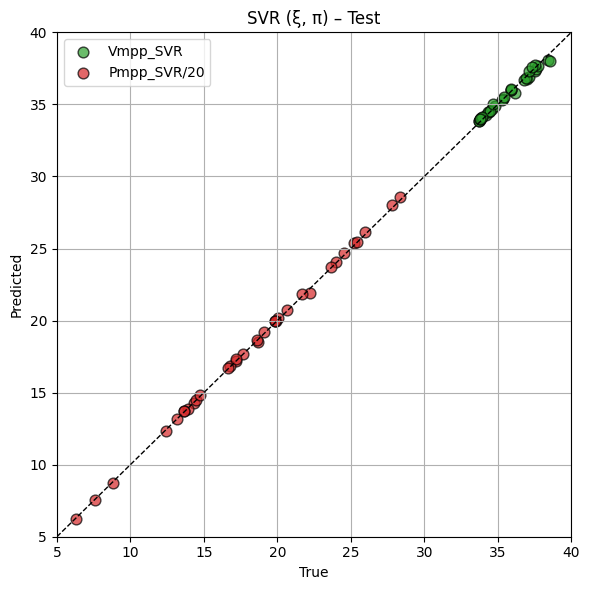


✅  SVR 模型已保存为 svr_greybox_xi_pi.pkl


In [11]:
!pip install -q scikit-learn pandas numpy matplotlib joblib

import pandas as pd, numpy as np, matplotlib.pyplot as plt, joblib
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, GridSearchCV
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# ---------- 1. 读灰盒数据 --------------------------------------------
df = pd.read_csv('pv_mpp_dataset_graybox.csv')
df['gid'] = (df['Ir']//100)*100 + ((df['T']+0.1)//5)*5  # 按网格分组

# 划分 Train/Val/Test
gss = GroupShuffleSplit(test_size=0.2, random_state=0)
tr, te = next(gss.split(df, groups=df['gid']))
temp_tr = df.iloc[tr]
test_df = df.iloc[te]

# 再从 temp_tr 划出 Val
temp_tr = temp_tr.sample(frac=1, random_state=0)
split = int(0.8*len(temp_tr))
train_df = temp_tr.iloc[:split]
val_df   = temp_tr.iloc[split:]

print(f'Train={len(train_df)}  Val={len(val_df)}  Test={len(test_df)}')

# ---------- 2. 特征 & 归一化标签 -------------------------------
X_train = train_df[['Ir','T']]
X_val   = val_df[['Ir','T']]
X_test  = test_df[['Ir','T']]

y_train = train_df[['xi','pi']].values
y_val   = val_df[['xi','pi']].values
y_test  = test_df[['xi','pi']].values

# ---------- 3. SVR + GridSearchCV -----------------------------
base = MultiOutputRegressor(SVR())
pipe = make_pipeline(StandardScaler(), base)

param_grid = {
    'multioutputregressor__estimator__C':      [1,10,100],
    'multioutputregressor__estimator__gamma':  ['scale','auto'],
    'multioutputregressor__estimator__epsilon':[0.01,0.1,0.5]
}

gkf = GroupKFold(n_splits=5)
grid = GridSearchCV(pipe, param_grid,
                    cv=gkf.split(X_train, y_train[:,0], groups=train_df['gid']),
                    scoring='neg_root_mean_squared_error',
                    n_jobs=-1)
grid.fit(X_train, y_train)

best_svr = grid.best_estimator_
print('🛠  Best SVR params:', grid.best_params_)

# ---------- 4. 评估函数 --------------------------------------------
def rmse(a,b):
    return np.sqrt(mean_squared_error(a, b))

def evaluate(mdl, X, y_norm, meta_df, tag):
    pred_norm = mdl.predict(X)
    Vm_hat = pred_norm[:,0] * meta_df['Voc'].values
    Pm_hat = pred_norm[:,1] * meta_df['Voc'].values * meta_df['Isc'].values

    Vm_true, Pm_true = meta_df['Vmpp'].values, meta_df['Pmpp'].values
    rv = rmse(Vm_true, Vm_hat); r2v = r2_score(Vm_true, Vm_hat)
    rp = rmse(Pm_true, Pm_hat); r2p = r2_score(Pm_true, Pm_hat)
    print(f'{tag:<5}: Vmpp RMSE={rv:6.3f} V  R²={r2v:6.3f} | '
          f'Pmpp RMSE={rp:6.2f} W  R²={r2p:6.3f}')
    return Vm_hat, Pm_hat

print('\n--- SVR (ξ, π) 评估 ---')
_         = evaluate(best_svr, X_val,  y_val,  val_df,  'VAL')
Vm_svr, Pm_svr = evaluate(best_svr, X_test, y_test, test_df, 'TEST')

# ---------- 5. 画散点图：Test 上的对比 ----------------------------
plt.figure(figsize=(6,6))
plt.scatter(test_df['Vmpp'],    Vm_svr,
            c='tab:green', label='Vmpp_SVR',    alpha=.7, edgecolors='k', s=60)
plt.scatter(test_df['Pmpp']/20, Pm_svr/20,
            c='tab:red',   label='Pmpp_SVR/20', alpha=.7, edgecolors='k', s=60)

# 统一坐标轴范围
all_true = np.concatenate([test_df['Vmpp'],   test_df['Pmpp']/20])
all_pred = np.concatenate([Vm_svr,            Pm_svr/20])
low  = np.floor(min(all_true.min(), all_pred.min()) - 1)
high = np.ceil (max(all_true.max(), all_pred.max()) + 1)
plt.plot([low,high],[low,high], 'k--', lw=1)
plt.xlim(low,high); plt.ylim(low,high)

plt.xlabel('True'); plt.ylabel('Predicted')
plt.title('SVR (ξ, π) – Test'); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.show()

# ---------- 6. 保存模型（可选） -------------------------------
joblib.dump(best_svr, 'svr_greybox_xi_pi.pkl')
print('\n✅  SVR 模型已保存为 svr_greybox_xi_pi.pkl')




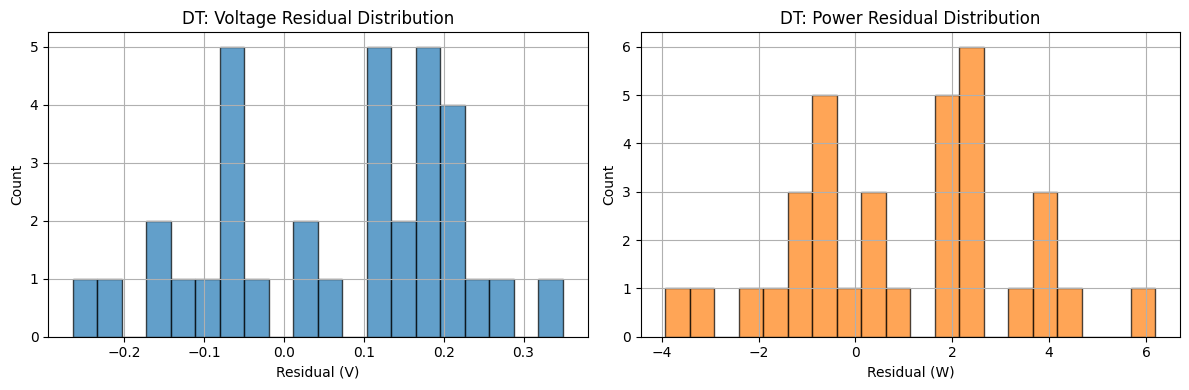

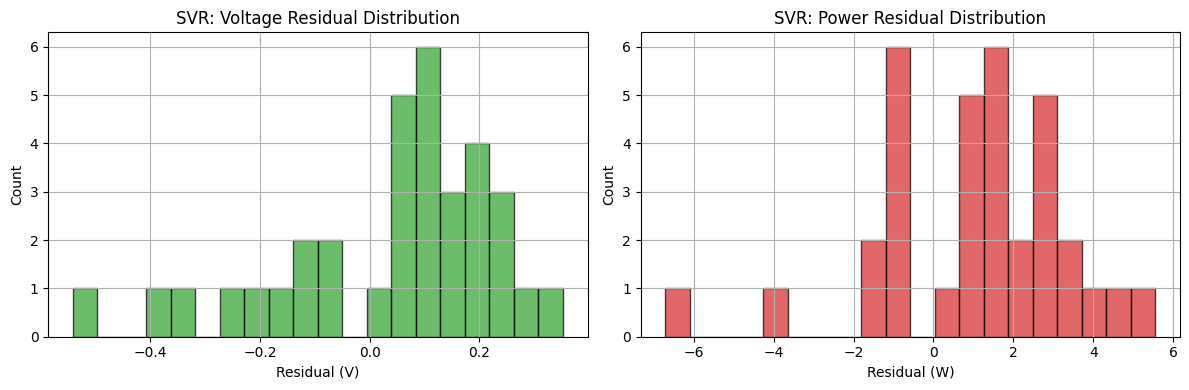

In [14]:
import matplotlib.pyplot as plt

# --------- 假设到这里你已得到了 DT 和 SVR 的预测结果 ----------
# Vm_hat, Pm_hat   = DT 模型在 TEST 上的预测 （已经有了）
# Vm_svr, Pm_svr = SVR 模型在 TEST 上的预测 （已经有了）
# test_df 包含真实的 Vmpp, Pmpp

# 1) 计算残差
res_v_dt  = Vm_hat  - test_df['Vmpp'].values
res_p_dt  = Pm_hat  - test_df['Pmpp'].values

res_v_svr = Vm_svr - test_df['Vmpp'].values
res_p_svr = Pm_svr - test_df['Pmpp'].values

# ---------- 2) DT 的残差分布 ----------
fig, axes = plt.subplots(1, 2, figsize=(12,4))

axes[0].hist(res_v_dt, bins=20, color='tab:blue', edgecolor='k', alpha=0.7)
axes[0].set_title('DT: Voltage Residual Distribution')
axes[0].set_xlabel('Residual (V)')
axes[0].set_ylabel('Count')
axes[0].grid(True)

axes[1].hist(res_p_dt, bins=20, color='tab:orange', edgecolor='k', alpha=0.7)
axes[1].set_title('DT: Power Residual Distribution')
axes[1].set_xlabel('Residual (W)')
axes[1].set_ylabel('Count')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# ---------- 3) SVR 的残差分布 ----------
fig, axes = plt.subplots(1, 2, figsize=(12,4))

axes[0].hist(res_v_svr, bins=20, color='tab:green', edgecolor='k', alpha=0.7)
axes[0].set_title('SVR: Voltage Residual Distribution')
axes[0].set_xlabel('Residual (V)')
axes[0].set_ylabel('Count')
axes[0].grid(True)

axes[1].hist(res_p_svr, bins=20, color='tab:red', edgecolor='k', alpha=0.7)
axes[1].set_title('SVR: Power Residual Distribution')
axes[1].set_xlabel('Residual (W)')
axes[1].set_ylabel('Count')
axes[1].grid(True)

plt.tight_layout()
plt.show()


*** DT Learning Curves ***


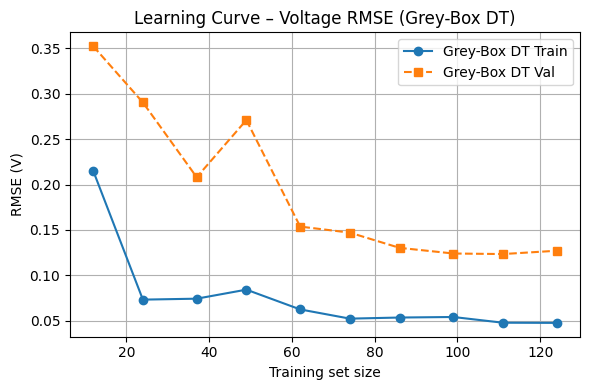

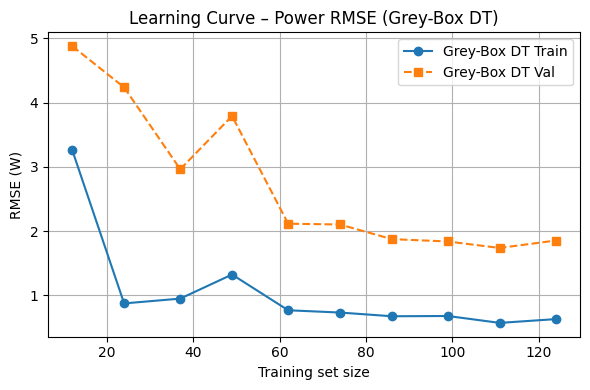

*** SVR Learning Curves ***


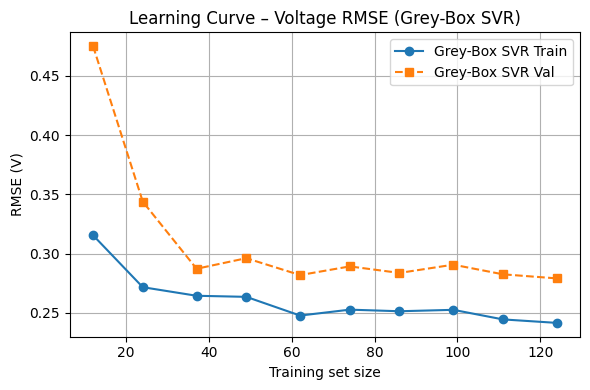

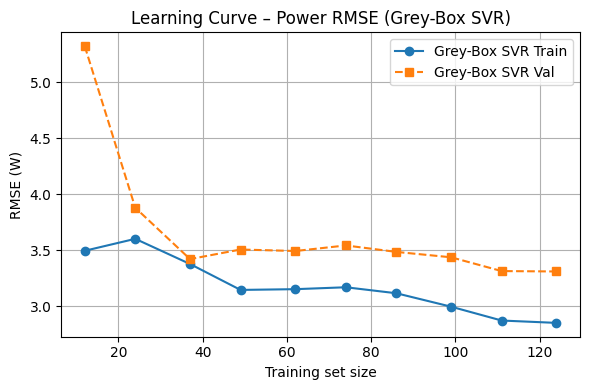

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import clone


def compute_learning_curve(model, X_train, y_train, meta_train, X_val, y_val, meta_val, train_df, val_df, tag):
    """
    对单个模型(model)计算学习曲线：
    - X_train, y_train: 归一化标签的训练集特征/标签
    - meta_train: 包含真实 Vmpp, Pmpp, Voc, Isc 的训练集 DataFrame
    - X_val, y_val, meta_val: 同理的验证集
    - train_df, val_df: 用来从 meta DataFrame 中按同样索引取 Voc/Isc/Vmpp/Pmpp
    - tag: 模型名字，用于图例
    """
    # 定义几个训练集规模比例
    fractions = np.linspace(0.1, 1.0, 10)
    size_list = []
    train_rmse_v, val_rmse_v = [], []
    train_rmse_p, val_rmse_p = [], []

    for frac in fractions:
        N = int(len(X_train) * frac)
        if N < 5:  # 太少没意义
            continue
        size_list.append(N)
        # 子集
        X_sub = X_train.iloc[:N]
        y_sub = y_train[:N]
        meta_sub = meta_train.iloc[:N]

        # 重新克隆并拟合
        m = clone(model)
        m.fit(X_sub, y_sub)

        # 1) 训练集误差
        pred_sub = m.predict(X_sub)
        Vm_sub = pred_sub[:,0] * meta_sub['Voc'].values
        Pm_sub = pred_sub[:,1] * meta_sub['Voc'].values * meta_sub['Isc'].values
        vm_true_sub = meta_sub['Vmpp'].values
        pm_true_sub = meta_sub['Pmpp'].values

        rmse_v_tr = np.sqrt(mean_squared_error(vm_true_sub, Vm_sub))
        rmse_p_tr = np.sqrt(mean_squared_error(pm_true_sub, Pm_sub))
        train_rmse_v.append(rmse_v_tr)
        train_rmse_p.append(rmse_p_tr)

        # 2) 验证集误差
        pred_val = m.predict(X_val)
        Vm_val = pred_val[:,0] * meta_val['Voc'].values
        Pm_val = pred_val[:,1] * meta_val['Voc'].values * meta_val['Isc'].values
        vm_true_val = meta_val['Vmpp'].values
        pm_true_val = meta_val['Pmpp'].values

        rmse_v_va = np.sqrt(mean_squared_error(vm_true_val, Vm_val))
        rmse_p_va = np.sqrt(mean_squared_error(pm_true_val, Pm_val))
        val_rmse_v.append(rmse_v_va)
        val_rmse_p.append(rmse_p_va)

    # 绘图：Voltage RMSE
    plt.figure(figsize=(6,4))
    plt.plot(size_list, train_rmse_v, 'o-', label=f'{tag} Train')
    plt.plot(size_list, val_rmse_v,   's--', label=f'{tag} Val')
    plt.xlabel('Training set size')
    plt.ylabel('RMSE (V)')
    plt.title(f'Learning Curve – Voltage RMSE ({tag})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 绘图：Power RMSE
    plt.figure(figsize=(6,4))
    plt.plot(size_list, train_rmse_p, 'o-', label=f'{tag} Train')
    plt.plot(size_list, val_rmse_p,   's--', label=f'{tag} Val')
    plt.xlabel('Training set size')
    plt.ylabel('RMSE (W)')
    plt.title(f'Learning Curve – Power RMSE ({tag})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# ------ 1) 对灰盒决策树 画学习曲线 ------
print('*** DT Learning Curves ***')
compute_learning_curve(
    model      = best_dt,
    X_train    = X_train,  y_train    = y_train,
    meta_train = train_df,
    X_val      = X_val,    y_val      = y_val,
    meta_val   = val_df,
    train_df   = train_df, val_df     = val_df,
    tag        = 'Grey-Box DT'
)

# ------ 2) 对 SVR 画学习曲线 ------
print('*** SVR Learning Curves ***')
compute_learning_curve(
    model      = best_svr,
    X_train    = X_train,  y_train    = y_train,
    meta_train = train_df,
    X_val      = X_val,    y_val      = y_val,
    meta_val   = val_df,
    train_df   = train_df, val_df     = val_df,
    tag        = 'Grey-Box SVR'
)




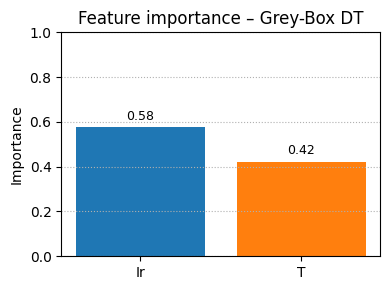

In [ ]:
imp = g_dt.named_steps['decisiontreeregressor'].feature_importances_
plt.figure(figsize=(4,3))
bars = plt.bar(['Ir','T'], imp, color=['tab:blue','tab:orange'])
for b,val in zip(bars, imp):
    plt.text(b.get_x()+b.get_width()/2, val+0.02, f'{val:.2f}',
             ha='center', va='bottom', fontsize=9)
plt.ylim(0,1); plt.ylabel('Importance')
plt.title('Feature importance – Grey-Box DT'); plt.grid(axis='y',ls=':')
plt.tight_layout(); plt.show()


DT   avg latency: 1.455 ms  ± 0.347 ms
SVR  avg latency: 2.043 ms  ± 0.376 ms


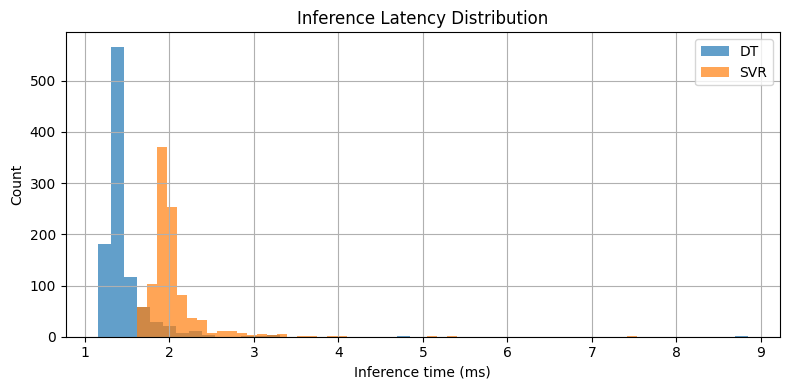

<ipython-input-16-380dbe0dd051>:48: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([dt_times, svr_times], labels=['DT','SVR'], showfliers=False)


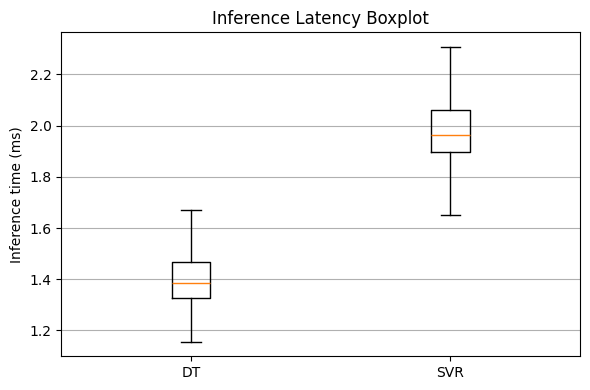

In [16]:
import time
import numpy as np
import matplotlib.pyplot as plt

# 我们已有：best_dt, best_svr, X_test, test_df, y_test

# 随机抽取测试集 1000 个样本来测延迟
n_calls = 1000
idxs = np.random.choice(len(X_test), size=n_calls, replace=True)

dt_times = []
svr_times = []
for i in idxs:
    x = X_test.iloc[[i]]

    # 决策树
    t0 = time.perf_counter()
    _ = best_dt.predict(x)
    t1 = time.perf_counter()
    dt_times.append((t1-t0)*1e3)   # ms

    # SVR
    t0 = time.perf_counter()
    _ = best_svr.predict(x)
    t1 = time.perf_counter()
    svr_times.append((t1-t0)*1e3)  # ms

dt_times = np.array(dt_times)
svr_times = np.array(svr_times)

print(f'DT   avg latency: {dt_times.mean():.3f} ms  ± {dt_times.std():.3f} ms')
print(f'SVR  avg latency: {svr_times.mean():.3f} ms  ± {svr_times.std():.3f} ms')

# ---- 直方图对比 ----
plt.figure(figsize=(8,4))
plt.hist(dt_times, bins=50, alpha=0.7, label='DT',    color='tab:blue')
plt.hist(svr_times,bins=50, alpha=0.7, label='SVR',   color='tab:orange')
plt.xlabel('Inference time (ms)')
plt.ylabel('Count')
plt.title('Inference Latency Distribution')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---- 箱形图对比 ----
plt.figure(figsize=(6,4))
plt.boxplot([dt_times, svr_times], labels=['DT','SVR'], showfliers=False)
plt.ylabel('Inference time (ms)')
plt.title('Inference Latency Boxplot')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()
